# A Well Conditioned Estimator of Large Covariance Matrices

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from covShrinkage.linear import IdentityShrinkage

In [2]:
n_vals = np.array([200, 160, 100, 80, 50, 40, 32, 25, 20, 16, 10, 8, 5, 4])
p_vals = np.array([4, 5, 8, 10, 16, 20, 25, 32, 40, 50, 80, 100, 160, 200])
PRIALs = np.zeros(len(n_vals))

In [3]:
R = 1000              
alpha2 = 0.5     
s2 = np.log(1 + alpha2)
m  = -0.5 * s2

np.random.seed(0)

In [4]:
for i in range(len(n_vals)):
    n = n_vals[i]
    p = p_vals[i]
    
    lambdas = np.random.lognormal(mean=m, sigma=np.sqrt(s2), size=p)
    lambdas /= np.mean(lambdas)

    true_sigma = np.diag(lambdas)

    sample_err = 0.0
    identity_err = 0.0
    
    for _ in range(R):
        Y = np.random.multivariate_normal(np.zeros(p), true_sigma, size=n)
        
        sample = np.cov(Y, rowvar=False)
        
        S_star = IdentityShrinkage().fit(Y)

        identity_shrinkage = S_star.covariance
        identity_sigmahat = S_star.covariance
        
        sample_err += np.linalg.norm(sample - true_sigma, ord='fro')**2
        identity_err += np.linalg.norm(identity_sigmahat - true_sigma, ord='fro')**2
    
    sample_err /= R
    identity_err /= R
    PRIALs[i] = 100 * (sample_err - identity_err) / sample_err

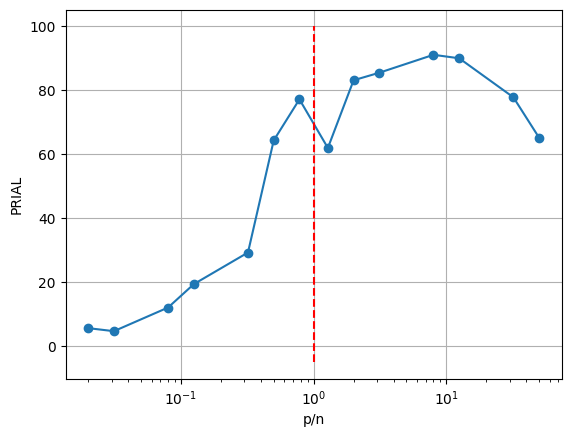

In [5]:
plt.semilogx([p/n for n, p in zip(n_vals, p_vals, strict=False)], PRIALs, marker='o')
plt.xlabel('p/n')
plt.ylabel('PRIAL')
plt.grid()
plt.vlines(1, -5, 100, colors='r', linestyles='dashed')

## Multi-Threaded Version

In [18]:
from concurrent.futures import ThreadPoolExecutor

def worker(n: int, p: int, R: int, m: float, s2: float, seed: int) -> float:
    """
    Compute PRIAL for one (n, p) setting.
    Matches your original pipeline: np.cov (1/(n-1)) and IdentityShrinkage().fit(Y).
    """
    rng = np.random.default_rng(seed)

    lambdas = rng.lognormal(mean=m, sigma=np.sqrt(s2), size=p)
    lambdas /= lambdas.mean()
    Sigma = np.diag(lambdas)

    sample_err = 0.0
    shrink_err = 0.0

    for _ in range(R):
        Y = rng.multivariate_normal(np.zeros(p), Sigma, size=n)

        S_unb = np.cov(Y, rowvar=False)              
        S_star = IdentityShrinkage().fit(Y).covariance

        sample_err += np.linalg.norm(S_unb - Sigma, 'fro')**2
        shrink_err += np.linalg.norm(S_star - Sigma, 'fro')**2

    sample_err /= R
    shrink_err /= R
    return 100.0 * (sample_err - shrink_err) / sample_err

In [ ]:
def run_prials_threads(n_vals, p_vals, R, m, s2, base_seed=42):
    PRIALs = np.empty(len(n_vals), dtype=float)
    with ThreadPoolExecutor() as ex:
        futs = [ex.submit(worker, int(n), int(p), R, m, s2, base_seed + i*9973)
                for i, (n, p) in enumerate(zip(n_vals, p_vals, strict=False))]
        for i, fut in enumerate(futs):
            PRIALs[i] = fut.result()
    return PRIALs

PRIALs = run_prials_threads(n_vals, p_vals, R, m, s2)

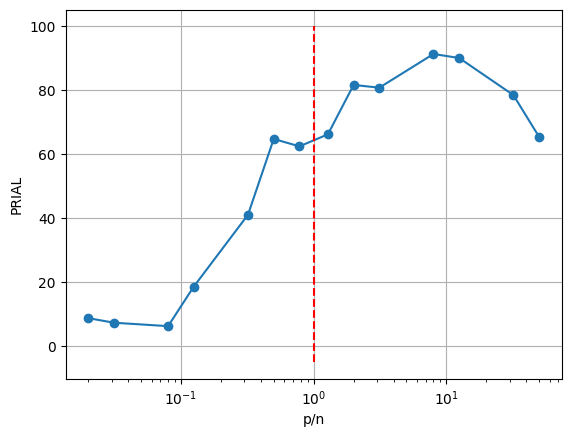

In [17]:
plt.semilogx([p/n for n, p in zip(n_vals, p_vals, strict=False)], PRIALs, marker='o')
plt.xlabel('p/n')
plt.ylabel('PRIAL')
plt.grid()
plt.vlines(1, -5, 100, colors='r', linestyles='dashed')